In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imblearn.under_sampling import CondensedNearestNeighbour, EditedNearestNeighbours

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv('https://raw.githubusercontent.com/JusciAvelino/Monitoria-ModelagemPreditivaDescritiva1/main/Breast%20Cancer%20Wisconsin%20(Diagnostic).csv')

In [3]:
X = dataset.drop([dataset.columns[0]], axis = 1)
y = dataset[dataset.columns[0]]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [5]:
colors = {"M": "steelblue", "B": "darkorange"}
markers = {"M": "s", "B": "^"}

#Função para visualizar uma região 2d, com duas features
def plot_2d_space(X, y, f1, f2, colors=colors, markers=markers):
    plt.figure()
    labels = list(y.unique())
    labels.sort()

    lines = []
    for i in labels:
        line = plt.scatter(
            X[f1][y==i],
            X[f2][y==i], 
            c=colors[i], 
            marker=markers[i],
            label=i,
        )

        lines.append(line)

    plt.legend(handles=lines)
        
    plt.show()

In [6]:
def percentage(train, resampled):
  excluidos = (train-resampled)
  percentage = 100 * float(excluidos)/float(train)
  return str(percentage) + "%"

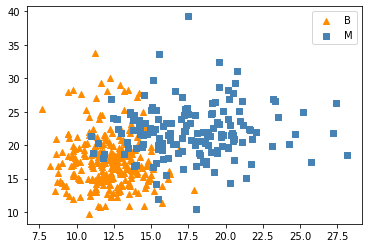

In [7]:
feature_0 = "radius_Mean"
feature_1 = "texture_Mean"

plot_2d_space(X_train, y_train, feature_0, feature_1)

In [8]:
y_train.value_counts()

B    271
M    155
Name: diagnosis, dtype: int64

In [9]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# vamos observar cada uma das classes usando duas features..

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           B       0.89      0.97      0.93        86
           M       0.94      0.82      0.88        57

    accuracy                           0.91       143
   macro avg       0.92      0.89      0.90       143
weighted avg       0.91      0.91      0.91       143



# **Seleção de instâncias**

# **ENN**

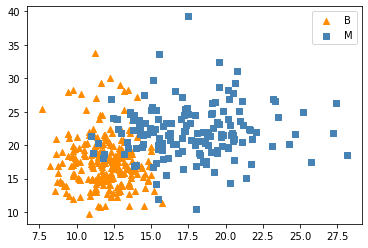

In [10]:
enn = EditedNearestNeighbours()
X_train_enn, y_train_enn = enn.fit_resample(X_train, y_train)

#Classes filtradas usando ENN
plot_2d_space(X_train_enn, y_train_enn, feature_0, feature_1)

In [11]:
y_train_enn.value_counts()

B    242
M    155
Name: diagnosis, dtype: int64

In [12]:
print("Porcentegem de redução:", percentage(y_train.count(), y_train_enn.count()))

Porcentegem de redução: 6.807511737089202%


In [13]:
model = KNeighborsClassifier()

model.fit(X_train_enn, y_train_enn)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           B       0.91      0.93      0.92        86
           M       0.89      0.86      0.88        57

    accuracy                           0.90       143
   macro avg       0.90      0.89      0.90       143
weighted avg       0.90      0.90      0.90       143



# **CNN**

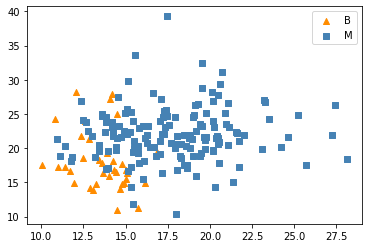

In [14]:
cnn = CondensedNearestNeighbour()
X_train_cnn, y_train_cnn = cnn.fit_resample(X_train, y_train)

#Classes filtradas usando CNN
plot_2d_space(X_train_cnn, y_train_cnn, feature_0, feature_1)

In [15]:
y_train_cnn.value_counts()

M    155
B     36
Name: diagnosis, dtype: int64

In [16]:
model = KNeighborsClassifier()

model.fit(X_train_cnn, y_train_cnn)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           B       0.93      0.95      0.94        86
           M       0.93      0.89      0.91        57

    accuracy                           0.93       143
   macro avg       0.93      0.92      0.93       143
weighted avg       0.93      0.93      0.93       143



In [17]:
print("Porcentegem de redução:", percentage(y_train.count(), y_train_cnn.count()))

Porcentegem de redução: 55.16431924882629%


# **SELEÇÃO DE ATRIBUTOS**

# **Filters**

# Limiar de Variância

O limiar de variância é o método mais simples de seleção de features. Caso a feature não tenha determinada variância, ela deve ser removida.

In [18]:
from sklearn.feature_selection import VarianceThreshold

filter_variance = VarianceThreshold(0.8)
X_filtered = filter_variance.fit_transform(X)

# quantas features conseguimos remover?
print("Features selecionadas: %d" %(X_filtered.shape[1]))

Features selecionadas: 10


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y)

In [20]:
model = KNeighborsClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           B       0.92      0.97      0.94        91
           M       0.94      0.85      0.89        52

    accuracy                           0.92       143
   macro avg       0.93      0.91      0.92       143
weighted avg       0.92      0.92      0.92       143



# **Wrapper**

Aqui, o processo de escolha de features depende de outros classificadores. Escolhemos um classificador linear, onde os coeficientes, ou medida de importância interna ao classificador, são utilizados para escolha das features mais importantes. Esse método é feito de forma recursiva, onde podemos controlar a quantidade de passos.

In [42]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

base_estimator = SVC(kernel="linear")
rfe = RFE(base_estimator, n_features_to_select=2, step=1)
X_filtered = rfe.fit_transform(X, y)

print(X_filtered.shape)

(569, 2)


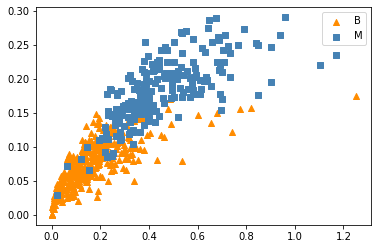

In [22]:
# visualizando as features selecionadas
df = pd.DataFrame(X_filtered, columns=[0, 1])
plot_2d_space(df, y, 0, 1)

In [47]:
rfe.feature_names_in_

array(['radius_Mean', 'texture_Mean', 'periMeter_Mean', 'area_Mean',
       'sMoothness_Mean', 'coMpactness_Mean', 'concavity_Mean',
       'concave points_Mean', 'syMMetry_Mean', 'fractal_diMension_Mean',
       'radius_se', 'texture_se', 'periMeter_se', 'area_se',
       'sMoothness_se', 'coMpactness_se', 'concavity_se',
       'concave points_se', 'syMMetry_se', 'fractal_diMension_se',
       'radius_worst', 'texture_worst', 'periMeter_worst', 'area_worst',
       'sMoothness_worst', 'coMpactness_worst', 'concavity_worst',
       'concave points_worst', 'syMMetry_worst',
       'fractal_diMension_worst'], dtype=object)

In [45]:
rfe.support_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True, False, False])

In [46]:
rfe.ranking_

array([ 7, 20, 15, 29, 12, 11,  8,  9, 10, 26, 24,  5, 13, 21, 22, 18, 17,
       19, 27, 25,  6, 14, 23, 28,  4,  3,  1,  1,  2, 16])